# Notebook to do correlations between muscle imaging and 1D signal


## Imports

In [1]:
import os
import sys
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pickle as cPickle

## Some params

In [2]:
# should we draw muscle outlines?
outline_flag = True

# define a list of muscle names
muscle_names = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii24', 'iii3',
                'hg1', 'hg2', 'hg3', 'hg4']

## Helper functions

In [3]:
def sig_correlations(sig,imgs):
    """ 
    calculate some summary images including the correlation image (from Thad's code)
    """
    # mean image
    mean_img = np.mean(imgs,axis=0)
    # mean subtracted
    zeroed_img = imgs - mean_img
    # max
    max_img = np.max(imgs,axis = 0)
    # norm of mean subtracted
    norm_img = np.linalg.norm(zeroed_img,axis = 0)
    # mean subtracted signal
    norm_sig = np.linalg.norm(sig-np.mean(sig))
    # correlation between 1D signal and image stack pixels
    dot_img = np.sum(zeroed_img*(sig[:,np.newaxis,np.newaxis]-np.mean(sig)),axis = 0)
    # dot_img = np.sum(zeroed_img*np.broadcast_to(sig-np.mean(sig), zeroed_img.T.shape).T,axis = 0)
    corr_img = dot_img/(norm_img*norm_sig)
    
    return {'mean_img':mean_img,
        'max_img':max_img,
        'norm_img':norm_img,
        'dot_img':dot_img,
        'corr_img':corr_img}


In [4]:
def sig_correlations_1d(sig, pix):
    """
    like sig_correlations, but just for a single pixel and just output correlation
    """
    # mean of pixel val
    mean_pix = np.mean(pix)
    # mean subtracted
    zeroed_pix = pix - mean_pix
    # norm of mean subtracted
    norm_pix = np.linalg.norm(zeroed_pix)
    # norm of mean subtracted signal
    norm_sig = np.linalg.norm(sig-np.mean(sig))
    # correlation between 1D signal and image stack pixel
    dot_pix = np.dot(zeroed_pix, (sig - np.mean(sig)))
    corr_pix = dot_pix/(norm_pix*norm_sig)
    
    return corr_pix

In [5]:
def draw_muscle_outlines(ax, outline_dict, line_width=0.75,  line_style='-', 
                         line_color='k', outline_alpha=1, muscle_names=muscle_names ):
    """
    Convenience function to create plot objects for muscle outlines on input axis
    
    outline_color = 'y'  #'r' 
    outline_lw = 0.75  # linewidth
    outline_alpha = 0.5
    outline_ls = ':'
    
    muscle_names = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii24', 'iii3',
                'hg1', 'hg2', 'hg3', 'hg4']
    """
    # initialize storage
    outline_plot_dict = dict()
    
    # need to add a condition for intializing plots
    for name in muscle_names:
        p, = ax.plot(outline_dict[name][0,:],outline_dict[name][1,:], ls=line_style, 
                     lw=line_width, color=line_color, label=name, alpha=outline_alpha)
        outline_plot_dict[name] = p
    
    # return our dictionary of plot objects
    return outline_plot_dict


In [6]:
def construct_rframe_dict(e1, e2):
    """Make a dictionary containing refrence frame info"""
    frame = dict()

    frame['e1'] = e1
    frame['e2'] = e2

    frame['a2'] = e1[1] - e2[0]
    frame['a1'] = e2[1] - e2[0]
    frame['p'] = e2[0]

    # also get transformation matrices based on these vectors
    frame['A'] = np.vstack((frame['a1'], frame['a2'])).T
    frame['A_inv'] = np.linalg.inv(frame['A'])

    return frame


In [7]:
def get_rframe_transform(self,other):
    """get transform into self from other frame (muscle imaging reference frames)"""
    A1 = np.hstack((self['A'],self['p'][:,np.newaxis]))
    A2 = np.hstack((other['A'],other['p'][:,np.newaxis]))
    A1 = np.vstack((A1, [0,0,1]))
    A2 = np.vstack((A2, [0,0,1]))

    return np.dot(A1, np.linalg.inv(A2))


## Load data

In [8]:
# which data set would we like to load?
fly_num = 1011
data_path = os.path.join('/media/sam/SamData/FlyDB/', 'Fly%04d'%fly_num)

thad_flag = True  # is this data coming from Thad's old drive?

# paths to data
data_fn_prefix = 'ca_camera_left'

rframe_fn = '{}_rframe_fits.cpkl'.format(data_fn_prefix)  # reference frame
img_fn = '{}.hdf5'.format(data_fn_prefix)                 # images
fit_fn = '{}_model_fits.cpkl'.format(data_fn_prefix)      # extracted GCaMP signals

In [9]:
# if data from thad, do a little work to convert to a format we understand
if thad_flag and not os.path.exists(os.path.join(data_path, img_fn)):
    # path to thad images
    img_fn_thad = 'fly_record.hdf5'
    
    # load images
    with h5py.File(os.path.join(data_path, img_fn_thad), 'r') as f:
        imgs = f['experiments']['roll_yaw']['tiff_data']['images'][:]
    
    # save images in more normal format
    chunk_size = 100
    im_h, im_w = imgs[0].shape[:2]
    chunks = (chunk_size, im_h, im_w)
    
#     # flip images
#     imgs = np.flip(imgs, axis=1)
    
    save_path = os.path.join(data_path, img_fn)
    with h5py.File(save_path, 'a') as h5f:
            h5f.create_dataset('cam_imgs', data=imgs, compression="gzip", chunks=chunks)
    
    
        

In [10]:
# # also save reference frame if getting from Thad
# if thad_flag and not os.path.exists(os.path.join(data_path, rframe_fn)):
#     # also save reference frame as pickle file
#     rframe = {'A': np.array([[-63.23762286,   2.10342471], [  3.56517018, -91.09647097]]), 
#               'a1': np.array([-63.23762286,   3.56517018]), 
#               'p': np.array([ 96.31317089, 127.76181723]), 
#               'a2': np.array([  2.10342471, -91.09647097]), 
#               'A_inv': np.array([[-0.01583398, -0.00036561], [-0.00061968, -0.01099168]])}
    
#     rframe_save_path = os.path.join(data_path, rframe_fn)
#     with open(rframe_save_path, 'wb') as fp:
#         cPickle.dump(rframe, fp, protocol=2)


In [11]:
# load images
with h5py.File(os.path.join(data_path, img_fn), 'r') as f:
    imgs = f['cam_imgs'][:]

    # print(f['experiments']['roll_yaw']['tiff_data'].keys())
    # imgs = f['experiments']['roll_yaw']['tiff_data']['images'][:]


In [12]:
# load model fits (extracted GCaMP signals)
with open(os.path.join(data_path, fit_fn), 'rb') as f:
    # model_fits = cPickle.load(f)
    model_fits = cPickle.load(f, encoding='latin1')
    

In [13]:
# load reference frame
with open(os.path.join(data_path, rframe_fn), 'rb') as f:
    data_rframe = cPickle.load(f, encoding='latin1')

# reshape the matrices if need be
data_rframe['A'] = np.reshape(data_rframe['A'],(2,2))
data_rframe['A_inv'] = np.reshape(data_rframe['A_inv'],(2,2))

## Get muscle outlines in data space

In [14]:
# load muscle outlines in confocal (untransformed) frame
outline_path = '/home/sam/Documents/code/muscle_imaging/planotaxis/models/thorax'
outline_fn = 'outlines.cpkl'

with open(os.path.join(outline_path, outline_fn), 'rb') as f:
    outline_dict = cPickle.load(f, encoding='latin1')

In [15]:
# construct outline frame 
outline_frame = construct_rframe_dict(outline_dict['e1'], outline_dict['e2'])


In [16]:
# warp these onto current data frame
confocal2video = get_rframe_transform(data_rframe, outline_frame)

for name in muscle_names:
    # read outline, warp it, and add it back to dict
    outline_curr = outline_dict[name]

    outline_curr_hom = np.vstack((outline_curr, np.ones((1,outline_curr.shape[1]))))
    outline_curr_warped = np.dot(confocal2video, outline_curr_hom)
    
    # NB: also need to subtract flip y coordinate to make it make sense
    outline_new = outline_curr_warped[:2,:]
    outline_new[1,:] = imgs.shape[1] - outline_new[1,:] 
    
    outline_dict[name] = outline_new
    

## Try to find periods of high muscle activity?

In [17]:
# use ROI signals?
# iii3 is the 5th (idx 4) in tjhe image
# hg3 (which I used to look at hg4) is the 7th (idx 6)
roi_flag = True

if roi_flag:
    roi_fn = '{}_sq_int.cpkl'.format(data_fn_prefix)
    
    with open(os.path.join(data_path, roi_fn), 'rb') as f:
        roi_fits = cPickle.load(f, encoding='latin1')

Text(0.5, 1.0, 'hg4')

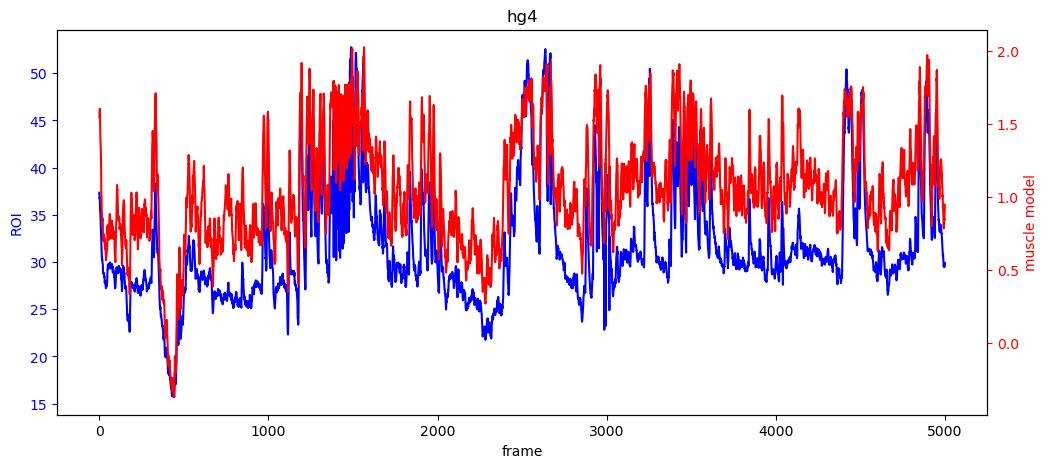

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
twin1 = ax.twinx()

muscle_name = 'hg4'
muscle_ind = 6 

# ax.plot(model_fits[muscle_name])
idx = slice(50000, 55000)
p1, = ax.plot(roi_fits[0][:,muscle_ind][idx], 'b')
p2, = twin1.plot(model_fits[muscle_name][idx], 'r-')

ax.set(xlabel="frame", ylabel="ROI")
twin1.set(ylabel="muscle model")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.set_title(muscle_name)

In [48]:
# fig, ax = plt.subplots(figsize=(12, 5))

# muscle_name = 'hg4'
# ax.plot(model_fits[muscle_name])

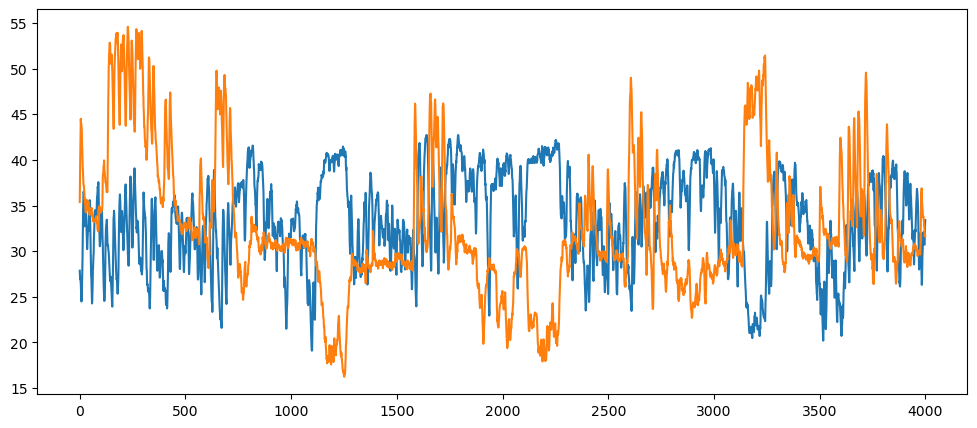

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))

# # This is a good range for 1011
# idx_start = 73000  # 5000
# idx_end = 75000  # 10000

# from 1012
idx_start = 20000
idx_end = 24000

ax.plot(roi_fits[0][:,4][idx_start:idx_end])
ax.plot(roi_fits[0][:,6][idx_start:idx_end])

# ax.plot(model_fits[muscle_name][idx_start:idx_end])
# ax.plot(model_fits['hg4'][idx_start:idx_end])

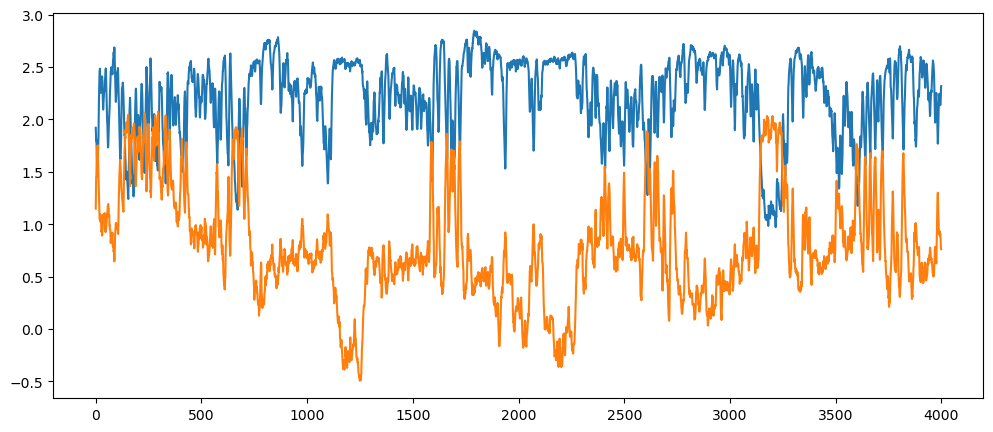

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))

# ax.plot(roi_fits[0][:,4][idx_start:idx_end])
# ax.plot(roi_fits[0][:,6][idx_start:idx_end])

ax.plot(model_fits['iii3'][idx_start:idx_end])
ax.plot(model_fits['hg4'][idx_start:idx_end])

## Calculate correlation images

In [54]:
# pick which muscle to get correlation against
muscle_name = 'hg4'  # 'iii3'
muscle_signal = model_fits[muscle_name]


In [55]:
# get correlation image
# idx_start = 0
# idx_end = 4000
corr_output = sig_correlations(muscle_signal[idx_start:idx_end], imgs[idx_start:idx_end,:,:])


Text(0.5, 1.0, 'correlation with hg4')

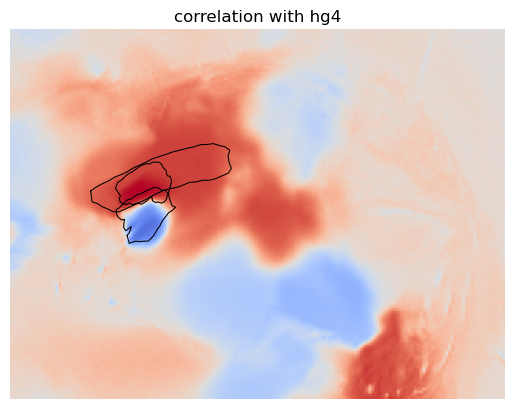

In [58]:
# visualize results
fig, ax = plt.subplots()

# read out image
corr_img = corr_output['corr_img']

# set upper and lower color limit bound
# clim_val = np.percentile(np.abs(corr_img), 98)  # clim_val = np.max(np.abs(corr_img))
clim_val = np.max(np.abs(corr_img))

ax.imshow(corr_img, cmap='coolwarm', vmin=-clim_val, vmax=clim_val)

# draw muscle outlines on top?
if outline_flag:
    outline_plots = draw_muscle_outlines(ax, outline_dict, muscle_names=['iii3', 'hg4', 'i2'])

# turn off axis ticks
ax.axis('off')
ax.set_title('correlation with {}'.format(muscle_name))

In [1]:
# # get correlation image
# idx_start = 0
# idx_end = 10000
# corr_output = sig_correlations(muscle_signal[idx_start:idx_end], imgs[idx_start:idx_end,:,:])

In [2]:
np.mean(corr_img)

NameError: name 'np' is not defined

## Try in a method that let's us do the whole video

In [ ]:
# pick which muscle to get correlation against
muscle_name = 'iii3'

muscle_signal = model_fits[muscle_name]

In [ ]:
# try on just one pixel
r = 0
c = 10
corr_pix = sig_correlations_1d(muscle_signal[idx_start:idx_end], np.squeeze(imgs[idx_start:idx_end,r,c]))

print(corr_pix)
print(corr_pix - corr_img[r,c])

In [ ]:
# initialize output correlation image
_, n_rows, n_cols = imgs.shape
corr_img_out = np.zeros((n_rows, n_cols),dtype=np.float64)


In [ ]:
# # loop over pixels to get correlations
# for ith in range(n_rows):
#     for jth in range(n_cols):
#         # get correlations for just current pixel
#         corr_pix = sig_correlations_1d(muscle_signal, np.squeeze(imgs[:,ith,jth]))
        
#         # add pixel to image
#         corr_img_out[ith, jth] = corr_pix
        

In [ ]:
weight_path = '/media/sam/SamData/FlyDB/Fly0059'
with open(os.path.join(weight_path, 'weights_and_image.cpkl'), 'rb') as f:
        data_dict = cPickle.load(f, encoding='latin1')

In [ ]:
print(data_dict.keys())

In [ ]:
with h5py.File(os.path.join(data_path, img_fn), 'r') as f:
    img0 = f['cam_imgs'][0]

In [ ]:
data_dict['weight'].shape


In [ ]:
wt = data_dict['weight']

In [ ]:
# plt.imshow(np.sum(w,axis=0))

In [ ]:
wtw = wt @ wt.transpose()

plt.imshow(wtw)

In [ ]:
cond_num = np.linalg.cond(wtw)
print(cond_num)

In [ ]:
rnk = np.linalg.matrix_rank(wtw)
print(rnk)

In [ ]:
p = data_dict['image']
print(p.shape)

In [ ]:
b = wt @ p.ravel()

In [ ]:
print(b/np.max(b))